In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist
import numpy as np
import torch.nn.functional as F
from math import exp
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import math
import time
import torch.nn.utils as utils
from matplotlib import container

In [2]:
def gramacy(x):
    a = np.sin(10.*np.pi*x)/(2.*x)
    b = (x-1.)**4.
    ret= a+b
    return ret

In [3]:
def renormalize(x):
    delta1 = 1.-(-1.)
    delta2 = 2.5-0.5
    return (delta2 * (x - 1.) / delta1) + 2.5

In [4]:
np.random.seed(77)
torch.manual_seed(77)
    

#starting point
x0=torch.tensor([0.0])
step=20
future=0

hidden_size=64
sigma=0.1
n=2000

testing_loss=[]


In [5]:
def query(action):
    y_out=[]
    x_out=[]
    for i in range(action.size(0)):
        if action <-1.:
            action =torch.tensor([-1.0])
        if action >1.:
            action =torch.tensor([1.0])   
        x=renormalize(action)
        y=gramacy(x)
        x_out.extend([action])
        y_out.extend([y])
    x_out=np.array(x_out).reshape(action.size(0),1)
    x_out=torch.from_numpy(x_out[:]).double()
    y_out=np.array(y_out).reshape(action.size(0),1)
    y_out=torch.from_numpy(y_out[:,:]).double()
    input=torch.cat((x_out,y_out),1)
    return input,x_out,y_out 

In [6]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(2,hidden_size)
        self.linear1= nn.Linear(hidden_size,1)
        self.linear2= nn.Linear(hidden_size,1)
        self.tanh=nn.Tanh()
        
    def forward(self,input,sigma,future=0):
        outputs = []
        log_probs = []
        rewards = []
        entropies = []
        actions = []
        time_step=[]
        
        h_t = torch.zeros(input.size(0), hidden_size, requires_grad=False, dtype=torch.double).cuda()
        c_t = torch.zeros(input.size(0), hidden_size, requires_grad=False, dtype=torch.double).cuda()
        outputs += [input]
        t0 = time.time()
        for i in range(step+future):
            
            h_t, c_t = self.lstm1(input, (h_t, c_t))
            h_t=h_t.detach()
            c_t=c_t.detach()
            mean=self.linear1(h_t)
            mean=self.tanh(mean)
            #print('mean:',mean.detach().cpu().numpy())
            m = torch.distributions.normal.Normal(mean,sigma)
            action=m.sample()
            entropy=m.entropy()
            
            #print('action:',action)
            input,action_new,reward=query(action.cpu())
            #print('action:',action_new)
            log_prob=m.log_prob(action_new.cuda())
            input=input.cuda()
            outputs += [input]
            
            log_probs.append(log_prob)
            rewards.append(reward)
            entropies.append(entropy)
            actions.append(action_new)
            t1=time.time() - t0
            time_step.append(t1)
            
            
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs,log_probs,rewards,entropies,actions,time_step

In [7]:
def mins_found(rewards):
        min_step=[]    
        min_h=rewards[0].clone()
        for i in range(len(rewards)):
            for j in range(rewards[i].size(0)):
                if rewards[i][j]<min_h[j]:
                    min_h[j]=rewards[i][j]
            min_step.append(min_h.mean())
        return min_step

In [8]:
def min_loss(rewards):
        min_step=[]    
        min_h=rewards[0].clone()
        for i in range(len(rewards)):
            for j in range(rewards[i].size(0)):
                if rewards[i][j]<min_h[j]:
                    min_h[j]=rewards[i][j]
            min_step.append(min_h.clone())            
        return min_step

In [9]:
f=0
future=0
sigma=0.01
x0=x0.reshape(1,1)
y=gramacy(renormalize(x0)).reshape(1,1)
input_test=torch.cat((x0,y),1).cuda().double()

In [10]:
seq = Sequence().cuda()
seq.double()
seq.load_state_dict(torch.load('seq37_100.pkl')) #sum 31  #min 40  #oi 37 

In [11]:
steps=step+future
min_step_all=[]
t0 = time.time()
for i in range(100):
    with torch.no_grad():
        out_test,log_probs,test_rewards,entropies,test_actions,time_step = seq(input_test,sigma,future)
        t2=time.time() - t0
        min_stepp=mins_found(test_rewards)
        y = out_test.cpu().detach().numpy()
        
        min_step_all.append(min_stepp)

print('time : {:.02e} seconds'.format(t2))

time : 1.64e+00 seconds


In [12]:
min_all=np.array(min_step_all)   
sum_step=0
for i in range(len(min_all)):
    sum_step=sum_step+ min_all[i]
min_step =sum_step/len(min_all)
sum2=0
for i in range(len(min_all)):
    sum2=sum2+min_all[i]**2

var=sum2/len(min_all)-min_step**2
std=(var/len(min_all))**0.5

In [14]:
#rand
min_step_rand=[0]*20
sumxx2_rand=[0]*20
num=2000

for f in range(num):
    min=1
    for i in range(20):
        y=gramacy(np.random.uniform(0.5, 2.5))
        if y<min:
            min=y
        min_step_rand[i]+=min
        sumxx2_rand[i]+=min**2
std_rand=[]        
for i in range(20):
    std_rand.append(((sumxx2_rand[i]/num-(min_step_rand[i]/num)**2)/num)**0.5)
for i in range(20):
    min_step_rand[i]/=num

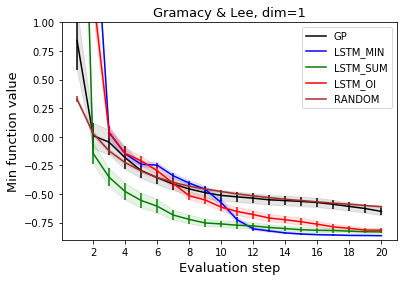

In [15]:
steps=np.arange(1,step+future+1, 1)

plt.xticks(np.arange(0, step+future+2, 2))

plt.fill_between(steps, min_step_gp-std_gp*2, min_step_gp+std_gp*2,color="black", alpha=0.1)
plt.fill_between(steps, np.asarray(min_step3)-np.asarray(std3)*2, np.asarray(min_step3)+np.asarray(std3)*2,color="blue", alpha=0.1) 
plt.fill_between(steps, np.asarray(min_step2)-np.asarray(std2)*2, np.asarray(min_step2)+np.asarray(std2)*2,color="green", alpha=0.1) 
plt.fill_between(steps, np.asarray(min_step)-np.asarray(std)*2, np.asarray(min_step)+np.asarray(std)*2,color="red", alpha=0.1)
plt.fill_between(steps, min_step_rand-np.asarray(std_rand)*2, min_step_rand+np.asarray(std_rand)*2,color="brown", alpha=0.1)


plt.errorbar(steps,min_step_gp, np.asarray(std_gp)*2,color='black',linestyle='-',linewidth=1.5,label='GP')
plt.errorbar(steps,min_step3, np.asarray(std3)*2,color='blue',linestyle='-',linewidth=1.5,label='LSTM_MIN')
plt.errorbar(steps,min_step2, np.asarray(std2)*2,color='green',linestyle='-',linewidth=1.5,label='LSTM_SUM')
plt.errorbar(steps,min_step, np.asarray(std)*2,color='red',linestyle='-',linewidth=1.5,label='LSTM_OI')
plt.errorbar(steps,min_step_rand, np.asarray(std_rand)*2,color='brown',linestyle='-',linewidth=1.5,label='RANDOM')

#remove errorbar in legend
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
handles = [h[0] if isinstance(h,container.ErrorbarContainer) else h for h in handles]

plt.legend(handles, labels,loc='upper right')
#plt.legend(handles, labels,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Min function value',size=13) 
plt.xlabel('Evaluation step',size=13) 
plt.title('Gramacy & Lee, dim=1',size=13)
plt.ylim(-0.9,1.)
#plt.savefig("min_step_gramacy.pdf", bbox_inches="tight")
plt.show()


In [16]:
#np.save('min_step_gramacy_min.npy',min_step3)
#np.save('std_gramacy_min.npy',std3)

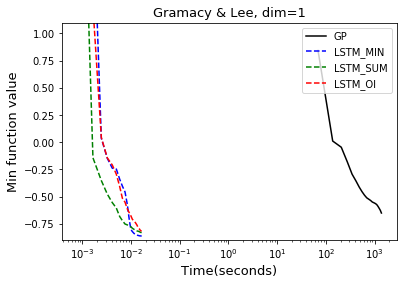

In [17]:
time_gp=1382
time_step_gp=[]
sum=0
for i in range(20):
    sum+=time_gp/20
    time_step_gp.append(sum)
plt.plot(time_step_gp,min_step_gp,'k',label='GP')
plt.plot(time_step,min_step3,'b--',label='LSTM_MIN')
plt.plot(time_step,min_step2,'g--',label='LSTM_SUM')
plt.plot(time_step,min_step,'r--',label='LSTM_OI')


#remove errorbar in legend
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
handles = [h[0] if isinstance(h,container.ErrorbarContainer) else h for h in handles]


#ax.legend(handles, labels,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend(handles, labels,loc='upper right')
plt.title('Gramacy & Lee, dim=1',size=13)
plt.ylabel('Min function value',size=13) 
plt.xlabel('Time(seconds)',size=13)

plt.xscale('log')
#plt.xlim(0,1.5)
plt.ylim(-0.9,1.1)
plt.savefig("min_time_gramacy.pdf",bbox_inches="tight")
plt.show()